In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd
import pickle
import ast

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

%matplotlib inline

# machine learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression

In [3]:
path = "The_Movies_Dataset/"
metadata = pd.read_csv( path + 'movies_metadata.csv')
ratings = pd.read_csv(path + "ratings.csv")
credits = pd.read_csv(path + "credits.csv")
user_metadata = pd.read_csv("./Movielens/users.dat",sep='::',names=['UserID','Gender','Age','Occupation','Zip-code'])
user_metadata.dropna(inplace=True)
metadata.head()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [4]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556


In [5]:
user_metadata.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [6]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

In [7]:
metadata_drop = metadata.dropna(subset=['budget'])

In [8]:
metadata_drop['revenue'] = metadata_drop['revenue'].replace(0, np.nan)

In [9]:
metadata_drop['budget'] = pd.to_numeric(metadata_drop['budget'], errors='coerce')
metadata_drop['budget'] = metadata_drop['budget'].replace(0, np.nan)
metadata_drop[metadata_drop['budget'].isnull()].shape

(36576, 24)

In [10]:
metadata_drop['adult'].value_counts()

False                                                                                                                             45454
True                                                                                                                                  9
 - Written by Ørnås                                                                                                                   1
 Avalanche Sharks tells the story of a bikini contest that turns into a horrifying affair when it is hit by a shark avalanche.        1
 Rune Balot goes to a casino connected to the October corporation to try to wrap up her case once and for all.                        1
Name: adult, dtype: int64

In [11]:
metadata_drop = metadata_drop.drop('adult', axis=1)

In [12]:
def clean_numeric(x):
    try:
        return float(x)
    except:
        return np.nan

In [13]:
metadata_drop['popularity'] = metadata_drop['popularity'].apply(clean_numeric).astype('float')
metadata_drop['vote_count'] = metadata_drop['vote_count'].apply(clean_numeric).astype('float')
metadata_drop['vote_average'] = metadata_drop['vote_average'].apply(clean_numeric).astype('float')

In [14]:
metadata_drop['popularity'].describe()

count    45460.000000
mean         2.921478
std          6.005414
min          0.000000
25%          0.385948
50%          1.127685
75%          3.678902
max        547.488298
Name: popularity, dtype: float64

In [15]:
metadata_drop['vote_average'] = metadata_drop['vote_average'].replace(0, np.nan)
metadata_drop['vote_average'].describe()

count    42462.000000
mean         6.014877
std          1.256208
min          0.500000
25%          5.300000
50%          6.100000
75%          6.900000
max         10.000000
Name: vote_average, dtype: float64

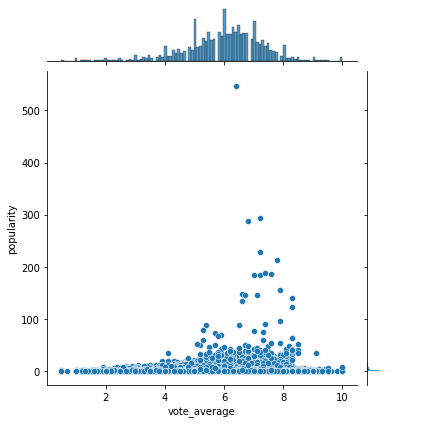

In [16]:
sns.jointplot(x='vote_average', y='popularity', data=metadata_drop)

In [18]:
print(metadata_drop.columns)
popularity_vote_average = metadata_drop[metadata_drop.vote_average > 7.0][["popularity", "vote_average"]]                                    
print(popularity_vote_average)

Index(['belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')
       popularity  vote_average
0       21.946943           7.7
5       17.924927           7.7
12      12.140733           7.1
13       5.092000           7.1
15      10.137389           7.8
...           ...           ...
45418    0.331254           8.0
45421    0.350365           7.2
45437   20.821780           8.3
45443    1.618458           7.6
45462    0.178241           9.0

[7714 rows x 2 columns]


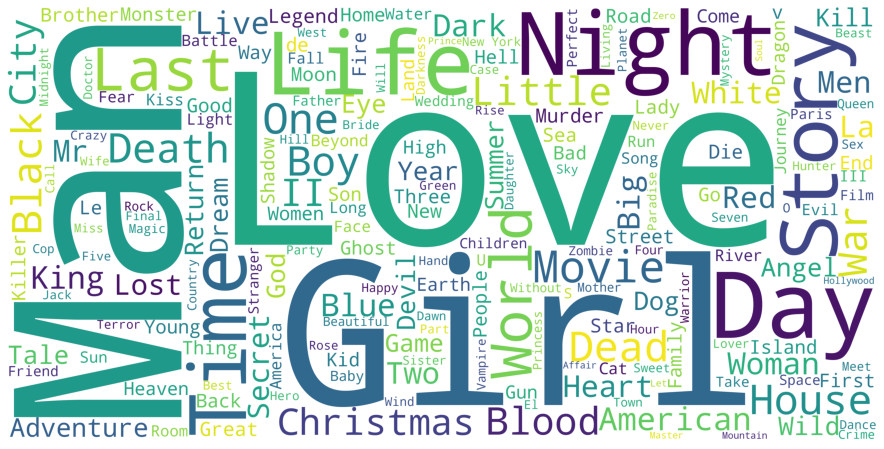

In [19]:
metadata_drop['title'] = metadata_drop['title'].astype('str')
metadata_drop['overview'] = metadata_drop['overview'].astype('str')
title_corpus = ' '.join(metadata_drop['title'])
overview_corpus = ' '.join(metadata_drop['overview'])
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(title_corpus)
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

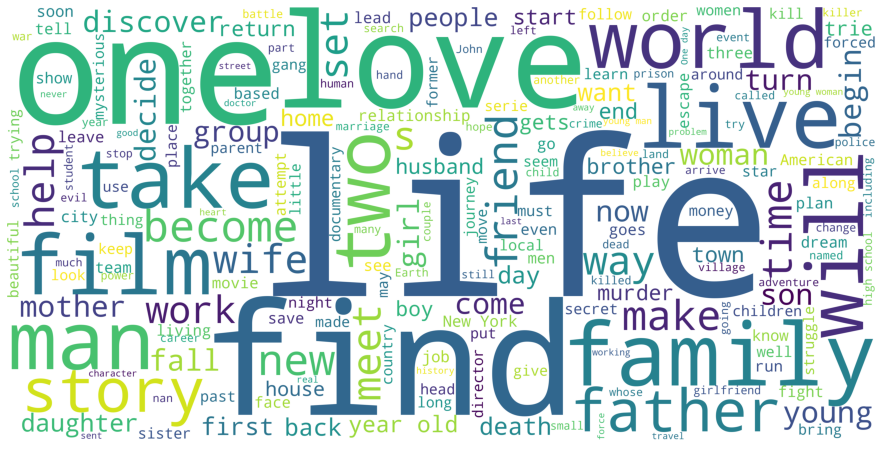

In [20]:
overview_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(overview_corpus)
plt.figure(figsize=(16,8))
plt.imshow(overview_wordcloud)
plt.axis('off')
plt.show()

In [21]:
metadata_drop['production_countries'] = metadata_drop['production_countries'].fillna('[]').apply(ast.literal_eval)
metadata_drop['production_countries'] = metadata_drop['production_countries'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [22]:
s = metadata_drop.apply(lambda x: pd.Series(x['production_countries']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'countries'

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


In [23]:
con_df = metadata_drop.drop('production_countries', axis=1).join(s)
con_df = pd.DataFrame(con_df['countries'].value_counts())
con_df['country'] = con_df.index
con_df.columns = ['num_movies', 'country']
con_df = con_df.reset_index().drop('index', axis=1)
con_df.head(10)

,num_movies,country
0,21153,United States of America
1,4094,United Kingdom
2,3940,France
3,2254,Germany
4,2169,Italy
5,1765,Canada
6,1648,Japan
7,964,Spain
8,912,Russia
9,828,India


In [24]:
metadata_drop['budget'].describe()

count    8.890000e+03
mean     2.160428e+07
std      3.431063e+07
min      1.000000e+00
25%      2.000000e+06
50%      8.000000e+06
75%      2.500000e+07
max      3.800000e+08
Name: budget, dtype: float64

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='budget', ylabel='Density'>

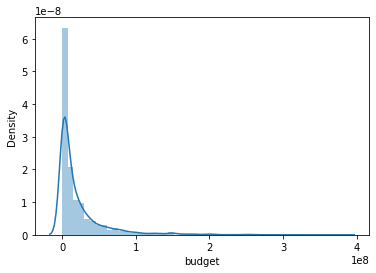

In [25]:
sns.distplot(metadata_drop[metadata_drop['budget'].notnull()]['budget'])

<AxesSubplot:ylabel='Frequency'>

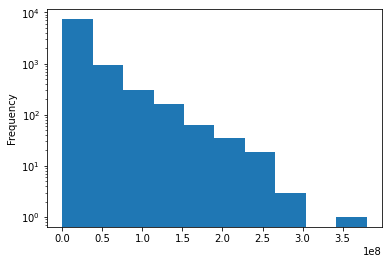

In [26]:
metadata_drop['budget'].plot(logy=True, kind='hist')

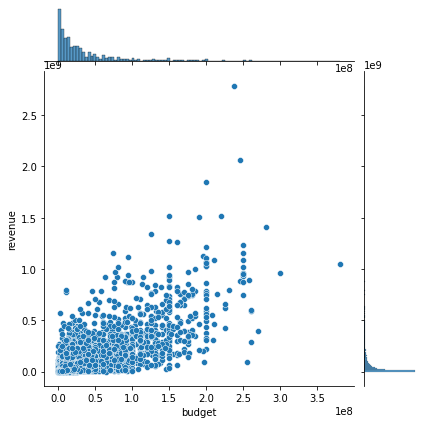

In [27]:
sns.jointplot(x='budget',y='revenue',data=metadata_drop[(metadata_drop['budget'].notnull()) & (metadata_drop['revenue'].notnull())])


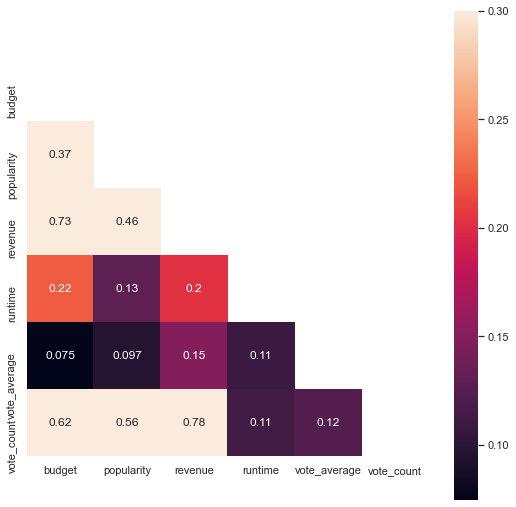

In [28]:
sns.set(font_scale=1)
corr = metadata_drop.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    plt.figure(figsize=(9,9))
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True, annot=True)

In [29]:
metadata_drop['genres_name'] = metadata_drop['genres'].fillna('[]').apply(ast.literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
metadata_drop['genres_id'] = metadata_drop['genres'].fillna('[]').apply(ast.literal_eval).apply(lambda x: [i['id'] for i in x] if isinstance(x, list) else [])
metadata_drop.head()

,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,...,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,genres_name,genres_id
0,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,...,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,"[Animation, Comedy, Family]","[16, 35, 10751]"
1,NaN,65000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,...,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"[Adventure, Fantasy, Family]","[12, 14, 10751]"
2,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",NaN,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.712900,...,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,"[Romance, Comedy]","[10749, 35]"
3,NaN,16000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,...,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,"[Comedy, Drama, Romance]","[35, 18, 10749]"
4,"{'id': 96871, 'name': 'Father of the Bride Col...",NaN,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,...,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,[Comedy],[35]


In [30]:
s = metadata_drop.apply(lambda x: pd.Series(x['genres_name']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genres_name'

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


In [31]:
gen_name_df = metadata_drop.drop('genres_name', axis=1).join(s)

In [32]:
gen_name_df['genres_name'].value_counts().shape[0]

32

In [33]:
pop_gen_name = pd.DataFrame(gen_name_df['genres_name'].value_counts()).reset_index()
pop_gen_name.columns = ['genres_name', 'movies']
pop_gen_name.head(10)

,genres_name,movies
0,Drama,20265
1,Comedy,13182
2,Thriller,7624
3,Romance,6735
4,Action,6596
5,Horror,4673
6,Crime,4307
7,Documentary,3932
8,Adventure,3496
9,Science Fiction,3049


In [34]:
s = metadata_drop.apply(lambda x: pd.Series(x['genres_id']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genres_id'
gen_id_df = metadata_drop.drop('genres_id', axis=1).join(s)
pop_gen_id = pd.DataFrame(gen_id_df['genres_id'].value_counts()).reset_index()
pop_gen_id.columns = ['genres_id', 'movies']
pop_gen_id.head(10)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


,genres_id,movies
0,18.0,20265
1,35.0,13182
2,53.0,7624
3,10749.0,6735
4,28.0,6596
5,27.0,4673
6,80.0,4307
7,99.0,3932
8,12.0,3496
9,878.0,3049


In [35]:
metadata_drop.head()

,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,...,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,genres_name,genres_id
0,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,...,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,"[Animation, Comedy, Family]","[16, 35, 10751]"
1,NaN,65000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,...,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"[Adventure, Fantasy, Family]","[12, 14, 10751]"
2,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",NaN,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.712900,...,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,"[Romance, Comedy]","[10749, 35]"
3,NaN,16000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,...,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,"[Comedy, Drama, Romance]","[35, 18, 10749]"
4,"{'id': 96871, 'name': 'Father of the Bride Col...",NaN,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,...,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,[Comedy],[35]


In [36]:
metadata_drop = metadata_drop[metadata_drop.release_date.notna()]

In [37]:
metadata_drop["release_year"] = metadata_drop.release_date.apply(lambda x:x.split("-")[0])

In [38]:
metadata_drop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45379 entries, 0 to 45465
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   belongs_to_collection  4491 non-null   object 
 1   budget                 8886 non-null   float64
 2   genres                 45379 non-null  object 
 3   homepage               7769 non-null   object 
 4   id                     45379 non-null  object 
 5   imdb_id                45365 non-null  object 
 6   original_language      45368 non-null  object 
 7   original_title         45379 non-null  object 
 8   overview               45379 non-null  object 
 9   popularity             45376 non-null  float64
 10  poster_path            45040 non-null  object 
 11  production_companies   45379 non-null  object 
 12  production_countries   45379 non-null  object 
 13  release_date           45379 non-null  object 
 14  revenue                7407 non-null   float64
 15  ru

In [52]:
metadata_after_prepocess = metadata_drop[["budget", "id", "production_countries", "original_language", "original_title", "popularity", "revenue", "runtime", "vote_average", "vote_count", "genres_name", "genres_id", "release_year"]].dropna()


In [44]:
metadata_after_prepocess.astype(str)["production_countries"]

0        ['United States of America']
1        ['United States of America']
3        ['United States of America']
5        ['United States of America']
8        ['United States of America']
                     ...             
45250                       ['India']
45399                      ['Russia']
45409                              []
45412                      ['Russia']
45422                      ['Russia']
Name: production_countries, Length: 5373, dtype: object

In [45]:
metadata_after_prepocess = metadata_after_prepocess[metadata_after_prepocess.astype(str)["production_countries"] != "[]"]
metadata_after_prepocess = metadata_after_prepocess[metadata_after_prepocess.astype(str)["genres_name"] != "[]"]
metadata_after_prepocess = metadata_after_prepocess[metadata_after_prepocess.astype(str)["genres_id"] != "[]"]


In [53]:
metadata_after_prepocess

,budget,id,production_countries,original_language,original_title,popularity,revenue,runtime,vote_average,vote_count,genres_name,genres_id,release_year
0,30000000.0,862,[United States of America],en,Toy Story,21.946943,373554033.0,81.0,7.7,5415.0,"[Animation, Comedy, Family]","[16, 35, 10751]",1995
1,65000000.0,8844,[United States of America],en,Jumanji,17.015539,262797249.0,104.0,6.9,2413.0,"[Adventure, Fantasy, Family]","[12, 14, 10751]",1995
3,16000000.0,31357,[United States of America],en,Waiting to Exhale,3.859495,81452156.0,127.0,6.1,34.0,"[Comedy, Drama, Romance]","[35, 18, 10749]",1995
5,60000000.0,949,[United States of America],en,Heat,17.924927,187436818.0,170.0,7.7,1886.0,"[Action, Crime, Drama, Thriller]","[28, 80, 18, 53]",1995
8,35000000.0,9091,[United States of America],en,Sudden Death,5.231580,64350171.0,106.0,5.5,174.0,"[Action, Adventure, Thriller]","[28, 12, 53]",1995
...,...,...,...,...,...,...,...,...,...,...,...,...,...
45250,12000000.0,24049,[India],ta,சிவாஜி,1.323587,19000000.0,185.0,6.9,25.0,"[Action, Comedy, Drama]","[28, 35, 18]",2007
45399,750000.0,280422,[Russia],ru,Все и сразу,0.201582,3.0,0.0,6.0,4.0,"[Crime, Comedy]","[80, 35]",2014
45409,800000.0,62757,[],en,Dikari,0.903061,1328612.0,100.0,5.8,6.0,"[Comedy, Drama]","[35, 18]",2006
45412,2000000.0,63281,[Russia],en,Про любоff,0.121844,1268793.0,107.0,4.0,3.0,"[Romance, Drama]","[10749, 18]",2010


In [55]:
metadata_drop = metadata_drop[["budget", "id", "production_countries", "original_language", "original_title", "popularity", "revenue", "runtime", "vote_average", "vote_count", "genres_name", "genres_id", "release_year"]]

In [56]:
metadata_drop = metadata_drop[metadata_drop.astype(str)["production_countries"] != "[]"]
metadata_drop = metadata_drop[metadata_drop.astype(str)["genres_name"] != "[]"]
metadata_drop = metadata_drop[metadata_drop.astype(str)["genres_id"] != "[]"]


In [58]:
metadata_drop.to_csv("movies_metadata_with_nan.csv", index=False)

In [46]:
metadata_after_prepocess.to_csv("prepocessed_movies_metadata.csv", index=False)

In [ ]:
metadata_after_prepocess_used = metadata_after_prepocess[metadata_after_prepocess['revenue'] >= 1000]
metadata_after_prepocess_used = metadata_after_prepocess[metadata_after_prepocess['budget'] >= 1000]
metadata_after_prepocess_used = metadata_after_prepocess[metadata_after_prepocess['score'] >= 0]
metadata_after_prepocess_used = metadata_after_prepocess[metadata_after_prepocess['runtime'] >= 0]
metadata_after_prepocess_used.info()

In [ ]:
X, y = metadata_after_prepocess_used[['budget']], metadata_after_prepocess_used['revenue']
lr = LinearRegression()
lr.fit(X, y)
print('R-squared: {:.4f}'.format(lr.score(X, y)))

In [ ]:
X, y = metadata_after_prepocess_used[['popularity']], metadata_after_prepocess_used['revenue']
lr = LinearRegression()
lr.fit(X, y)
print('R-squared: {:.4f}'.format(lr.score(X, y)))

In [ ]:
X, y = metadata_after_prepocess_used[['vote_average']], metadata_after_prepocess_used['revenue']
lr = LinearRegression()
lr.fit(X, y)
print('R-squared: {:.4f}'.format(lr.score(X, y)))

In [ ]:
X, y = metadata_after_prepocess_used[['runtime']], metadata_after_prepocess_used['revenue']
lr = LinearRegression()
lr.fit(X, y)
print('R-squared: {:.4f}'.format(lr.score(X, y)))

In [ ]:
X, y = metadata_after_prepocess_used[['vote_count']], metadata_after_prepocess_used['revenue']
lr = LinearRegression()
lr.fit(X, y)
print('R-squared: {:.4f}'.format(lr.score(X, y)))

In [ ]:
user_metadata.info()

In [ ]:
ratings.info()

In [ ]:
user_rating_df = pd.merge(ratings, user_metadata, left_on='userId', right_on='UserID').drop("UserID", axis=1)

In [ ]:
user_rating_df.head()

In [ ]:
user_rating_df.to_csv("rating_with_user_metadata.csv", index=False)